In [224]:
# Import libraries to be used.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [225]:
# Define a random state value
RANDOM_STATE = 3030

In [226]:
# Define column names which will be used instead of the ones in the datasets.
column_names = [
    "age", "sex", "chest_pain_type", "rest_bp", "cholesterol",
    "fasting_bs", "resting_ecg", "max_hr", "exercise_angina", "st_exercise_depression",
    "st_exercise_slope", "major_vessels_fluorospy", "thal", "angiographic_disease"
]
na_values = ["?"] # Define what values will be interpreted as missing values, in this dataset the "?" character is used for this.

# Load all datasets using relative paths and combine into one dataframe.
df = pd.concat([
    pd.read_csv("../data/processed.cleveland.data", names=column_names, na_values=na_values),
    pd.read_csv("../data/processed.hungarian.data", names=column_names, na_values=na_values),
    pd.read_csv("../data/processed.switzerland.data", names=column_names, na_values=na_values),
    pd.read_csv("../data/processed.va.data", names=column_names, na_values=na_values)
]).drop(['st_exercise_slope', 'major_vessels_fluorospy', 'thal'], axis=1)

In [227]:
df[df["angiographic_disease"] > 1] = 1

In [228]:
df['age'].fillna((df['age'].mean()), inplace=True)
df['rest_bp'].fillna((df['rest_bp'].mean()), inplace=True)
df['cholesterol'].fillna((df['cholesterol'].mean()), inplace=True)
df['max_hr'].fillna((df['max_hr'].mean()), inplace=True)
df['st_exercise_depression'].fillna((df['st_exercise_depression'].mean()), inplace=True)
df = df.apply(lambda x:x.fillna(x.value_counts().index[0]))

In [229]:
# Set category attributes
df["sex"] = df["sex"].astype("category")
df["chest_pain_type"] = df["chest_pain_type"].astype("category")
df["fasting_bs"] = df["fasting_bs"].astype("category")
df["resting_ecg"] = df["resting_ecg"].astype("category")
df["exercise_angina"] = df["exercise_angina"].astype("category")
df["angiographic_disease"] = df["angiographic_disease"].astype("category")

In [230]:
df_X = df.drop(["angiographic_disease"], axis=1)

In [231]:
df_X.head()

,age,sex,chest_pain_type,rest_bp,cholesterol,fasting_bs,resting_ecg,max_hr,exercise_angina,st_exercise_depression
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4


In [232]:
from sklearn.preprocessing import MinMaxScaler

In [233]:
X = MinMaxScaler().fit_transform(df_X.to_numpy())
y = df["angiographic_disease"].to_numpy()

In [234]:
X.shape

(920, 10)

In [235]:
y.shape

(920,)

### Train-test partitioning

In [238]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

### Implementing Random Forest (RF)

In [241]:
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
t_start = time.time()

rf_classifier = RandomForestClassifier(n_estimators=10, max_depth=None, criterion="entropy")
rf_classifier.fit(X_train, y_train) # training set, training labels
y_predicted = rf_classifier.predict(X_test)

print("According to the RF classifier, the class labels in the test set are: ", y_predicted)

# At the end we calculate the end time
t_end = time.time()
t_elapsed = t_end - t_start

print(f"The elapsed time of the function is {t_elapsed} seconds")
print (rf_classifier.score(X_train, y_train))
print(rf_classifier.score(X_test, y_test))

According to the RF classifier, the class labels in the test set are:  [0 1 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 1 0 1 1 1 0 0 0 1 1 0 1 1 1 1 1 0 0 0
 0 1 1 1 0 0 1 1 1 1 0 1 0 1 1 0 1 1 1 0 0 0 1 1 1 0 0 1 1 0 0 0 0 1 0 0 1
 0 1 1 0 0 1 1 1 0 1 1 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 1 1 1 1 0 1 1 0 1 0
 0 1 1 0 1 0 0 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 1 0 0 1 0 0 1 0 0 0 1 1 1 0 0
 1 0 1 1 0 0 1 1 1 1 1 1 1 0 0 0 0 1 0 1 0 0 1 0 1 1 1 0 1 1 1 1 0 0 1 0]
The elapsed time of the function is 0.03447318077087402 seconds
0.9904891304347826
0.8260869565217391


The model scores close to 100% accuracy on the training data and a lower 83% on the testing data. Since the training accuracy is so high and the testing is not as close, it’s safe to say the model is overfitting—the model is modeling the training data too well and not generalizing what it’s learning. 

### Tuning the Random Forest

The parameters to be tuned can be found in the sklearn documentation. One way to tune these parameters is to perform a random grid search. We define a range of values from which the code can randomly pick and choose until it finds a set that performs the best. To begin we define values the search algorithm will search through.

In [243]:
# Number of trees in random forest
n_estimators = np.linspace(100, 3000, int((3000-100)/200) + 1, dtype=int)
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [1, 5, 10, 20, 50, 75, 100, 150, 200]
# Minimum number of samples required to split a node
# min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 10, num = 9)]
min_samples_split = [1, 2, 5, 10, 15, 20, 30]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 3, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Criterion
criterion=['gini', 'entropy']
random_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'criterion': criterion}

In [244]:
rf_base = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf_base,
                               param_distributions = random_grid,
                               n_iter = 30, cv = 5,
                               verbose=2,
                               random_state=42, n_jobs = 4)
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
15 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 476, in fit
    trees = Parallel(
  File "/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/anaconda3/lib/python3.9/site-packages/j

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=30,
                   n_jobs=4,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [1, 5, 10, 20, 50, 75, 100,
                                                      150, 200],
                                        'min_samples_leaf': [1, 2, 3, 4],
                                        'min_samples_split': [1, 2, 5, 10, 15,
                                                              20, 30],
                                        'n_estimators': array([ 100,  307,  514,  721,  928, 1135, 1342, 1550, 1757, 1964, 2171,
       2378, 2585, 2792, 3000])},
                   random_state=42, verbose=2)

We can also view the parameter values the random search found:

In [245]:
rf_random.best_params_

{'n_estimators': 307,
 'min_samples_split': 2,
 'min_samples_leaf': 3,
 'max_depth': 5,
 'criterion': 'entropy',
 'bootstrap': True}

Lets evaluate our model again

In [289]:
print(rf_random.score(X_train, y_train))
print(rf_random.score(X_test, y_test))

0.8817934782608695
0.8152173913043478


We now see the training score is less than 90%, and the testing score is 81.52%. The model doesn’t appear to be overfitting as much as before.

Now that we have parameter values from the randomized grid search, we can use these as a starting point for a grid search. A grid search works, in principle, similarly to the randomized grid search as it will search through the parameter space we define. However, instead of searching random values it will search every value possible in the parameter space. This computation can be expensive because the search grows very fast as more parameters and search values for those parameters increasess. This is why we performed the random grid search first. We save on compute power and only perform a fine methodological search once we have a good starting point. Instantiating a grid search is also similar to instantiating the random grid search.

In [247]:
param_grid = {
    'n_estimators': np.linspace(2100, 2300, 5, dtype = int),
    'max_depth': [170, 180, 190, 200, 210, 220],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [2, 3, 4, 5]
}

We can then retrain yet another random forest.

In [248]:
from sklearn.model_selection import GridSearchCV

# Base model
rf_grid = RandomForestClassifier(criterion = 'entropy', bootstrap = True)
# Instantiate the grid search model
grid_rf_search = GridSearchCV(estimator = rf_grid, param_grid = param_grid, 
                          cv = 5, n_jobs = 8, verbose = 2)
grid_rf_search.fit(X_train, y_train)

Fitting 5 folds for each of 360 candidates, totalling 1800 fits
[CV] END bootstrap=True, criterion=entropy, max_depth=200, min_samples_leaf=2, min_samples_split=2, n_estimators=2171; total time=   4.5s
[CV] END bootstrap=True, criterion=gini, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=1135; total time=   1.8s
[CV] END bootstrap=True, criterion=gini, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=1135; total time=   1.8s
[CV] END bootstrap=True, criterion=entropy, max_depth=20, min_samples_leaf=4, min_samples_split=5, n_estimators=1135; total time=   1.8s
[CV] END bootstrap=False, criterion=entropy, max_depth=50, min_samples_leaf=4, min_samples_split=20, n_estimators=1757; total time=   2.4s
[CV] END bootstrap=True, criterion=entropy, max_depth=20, min_samples_leaf=2, min_samples_split=10, n_estimators=307; total time=   0.5s
[CV] END bootstrap=True, criterion=entropy, max_depth=20, min_samples_leaf=2, min_samples_split=10, n_estimators=307;

GridSearchCV(cv=5, estimator=RandomForestClassifier(criterion='entropy'),
             n_jobs=8,
             param_grid={'max_depth': [170, 180, 190, 200, 210, 220],
                         'min_samples_leaf': [2, 3, 4, 5],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': array([2100, 2150, 2200, 2250, 2300])},
             verbose=2)

And view what it found to be the most optimal set of parameters

In [249]:
best_rf_grid = grid_rf_search.best_estimator_
grid_rf_search.best_params_

{'max_depth': 170,
 'min_samples_leaf': 5,
 'min_samples_split': 4,
 'n_estimators': 2100}

Now we can evaluate this model to determine it’s accuracy and performance.

In [264]:
print(grid_rf_search.score(X_train, y_train))
print(grid_rf_search.score(X_test, y_test))

0.9035326086956522
0.8315217391304348


As we can see, it performed better than the randomized search but was significantly more computationally expensive. Now, lets use these hyperparameters.

### Performing KFold validation

In [276]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5)
CV_indices = kf.split(X_train, y_train)

In [280]:
for train_index, test_index in CV_indices:
    print("TRAIN:", train_index.shape, "TEST:", test_index.shape)

TRAIN: (588,) TEST: (148,)
TRAIN: (589,) TEST: (147,)
TRAIN: (589,) TEST: (147,)
TRAIN: (589,) TEST: (147,)
TRAIN: (589,) TEST: (147,)


In [281]:
from sklearn.model_selection import cross_validate

In [291]:
# We will apply the classifiers on the normalized dataset

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_X_norm = scaler.fit_transform(df_X)

print(f"X_train min. value: {X_train.min()}, max. value: {X_train.max()}")

X_train min. value: 0.0, max. value: 1.0


In [292]:
from sklearn.ensemble import RandomForestClassifier

MODELS_TO_TEST = {
    "RF_2100": RandomForestClassifier(n_estimators=2100, max_depth=170, min_samples_leaf=5)
}

# Define the number of splits 
NUMBER_OF_SPLITS = 4

# Scoring metrics
SCORING_METRICS = ["accuracy", "precision_macro", "recall_macro", "f1_macro"] # Metrics of interest

# Create empty DataFrame to populate  the name of the classifier and the six values returned from `cross_validate()`
results_evaluation = pd.DataFrame({
                                    "classifier_name":[],
                                    "fit_time": [],
                                    "score_time": [],
                                    "test_accuracy": [],
                                    "test_precision_macro": [],
                                    "test_recall_macro": [],
                                    "test_f1_macro": [],
                                    })

In [293]:
#### ITERATION FOR THE EXPERIMENT

for name, classifier in MODELS_TO_TEST.items():
    
    print(f"Currently training the classifier {name}.")

    # Get the evaluation metrics per fold after cross-validation
    # Note that we are passing the normalized array `df_X_norm` to all classifiers
    scores_cv = cross_validate(classifier, X_train, y_train, cv=NUMBER_OF_SPLITS, scoring=SCORING_METRICS)

    # Average the scores among folds
    dict_this_result = {
                    "classifier_name":[name],
                    }
    # Populate the dictionary with the results of the cross-validation
    for metric_name, score_per_fold in scores_cv.items():
        dict_this_result[metric_name] = [ scores_cv[metric_name].mean() ]

    #### Generate the results to populate the pandas.DataFrame
    this_result = pd.DataFrame(dict_this_result)

    # Append to the main dataframe with the results 
    results_evaluation = pd.concat([results_evaluation, this_result], ignore_index=True)

print("The experimental setup has finished")

Currently training the classifier RF_2100.
The experimental setup has finished


In [294]:
results_evaluation

,classifier_name,fit_time,score_time,test_accuracy,test_precision_macro,test_recall_macro,test_f1_macro
0,RF_2100,2.682705,0.238822,0.839674,0.839099,0.842297,0.838831


### Visualization

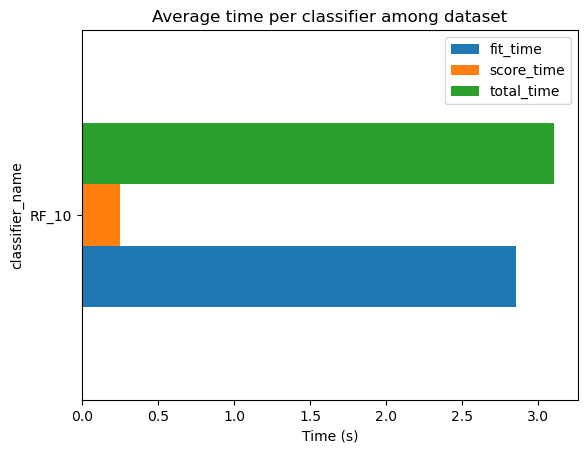

In [296]:
average_time_classifier.plot.barh()
plt.title("Average time per classifier among dataset")
plt.xlabel("Time (s)")
plt.show()

In [297]:
accuracy_classifier = results_evaluation.groupby(by=["classifier_name"]).mean()
accuracy_classifier.drop(["test_accuracy", "fit_time", "score_time", "test_precision_macro", "test_recall_macro"],axis=1,inplace=True) # Delete unnecessary features
#accuracy_classifier["total_time"] = average_time_classifier["fit_time"] + average_time_classifier["score_time"] # Create new features
accuracy_classifier

,test_f1_macro
classifier_name,
RF_2100,0.838831


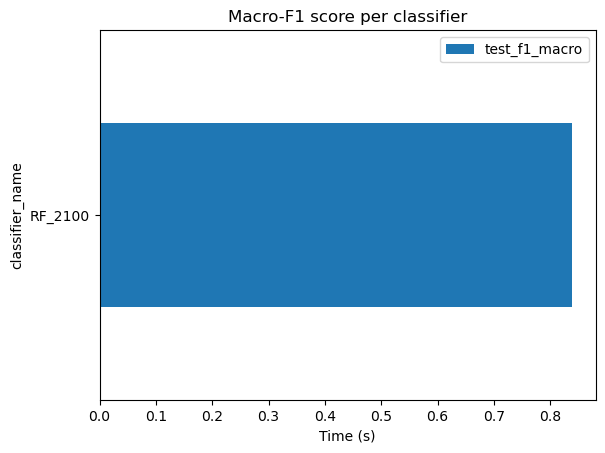

In [298]:
accuracy_classifier.plot.barh()
plt.title("Macro-F1 score per classifier")
plt.xlabel("Time (s)")
plt.show()